Note:  
This notebook was executed on google colab pro.

In [1]:
!pip3 install pytorch-lightning --quiet

     |████████████████████████████████| 813 kB 13.5 MB/s 
     |████████████████████████████████| 829 kB 28.5 MB/s 
     |████████████████████████████████| 636 kB 41.2 MB/s 
     |████████████████████████████████| 234 kB 50.2 MB/s 
     |████████████████████████████████| 118 kB 64.7 MB/s 
     |████████████████████████████████| 10.6 MB 59.1 MB/s 
     |████████████████████████████████| 1.3 MB 43.8 MB/s 
     |████████████████████████████████| 294 kB 55.3 MB/s 
     |████████████████████████████████| 142 kB 57.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [4]:
EXP_NO = 22
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [5]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [6]:
MODEL_NAME = 'squeezenet'
BATCH_SIZE = 128
NUM_EPOCHS = 200

# Library

In [7]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [10]:
output_dir = experiment_dir_of(EXP_NO)

In [11]:
output_dir

'../scripts/../experiments/exp022'

# Prepare logger

In [12]:
logger = getLogger(__name__)

In [13]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [14]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-21 04:42:23,203 - __main__ - INFO - Experiment no: 22
2021-07-21 04:42:23,206 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-21 04:42:23,209 - __main__ - INFO - SEED: 1
2021-07-21 04:42:23,212 - __main__ - INFO - REGRESSION: True


# Load csv files

In [15]:
SINCE = time.time()

In [16]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 04:42:23,232 - __main__ - DEBUG - Start loading csv files (0.009 seconds passed)
2021-07-21 04:42:25,177 - __main__ - DEBUG - Complete loading csv files (1.954 seconds passed)


In [17]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [18]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [19]:
seed_everything(SEED)

Global seed set to 1


1

In [20]:
train.set_index('object_id', inplace=True)

2021-07-21 04:42:25,762 - __main__ - DEBUG - Start fold 1 (2.539 seconds passed)
2021-07-21 04:42:25,771 - __main__ - DEBUG - Start training model (2.548 seconds passed)
2021-07-21 04:42:32,346 - __main__ - DEBUG - Epoch 0/199
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-21 04:47:44,875 - __main__ - DEBUG - train Loss: 10.5143
2021-07-21 04:49:07,162 - __main__ - DEBUG - val Loss: 1.0473
2021-07-21 04:49:07,173 - __main__ - DEBUG - Epoch 1/199
2021-07-21 04:49:15,250 - __main__ - DEBUG - train Loss: 1.0708
2021-07-21 04:49:17,503 - __main__ - DEBUG - val Loss: 0.9805
2021-07-21 04:49:17,513 - __main__ - DEBUG - Epoch 2/199
20

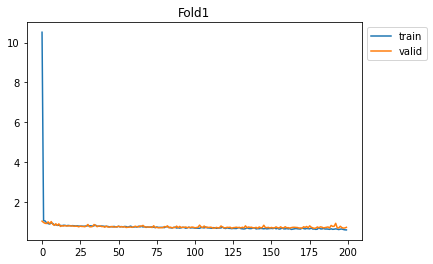

2021-07-21 05:22:59,711 - __main__ - DEBUG - Complete prediction for train fold (2436.489 seconds passed)
2021-07-21 05:23:01,952 - __main__ - DEBUG - Complete prediction for val fold (2438.729 seconds passed)
2021-07-21 05:35:13,157 - __main__ - DEBUG - Complete prediction for test fold (3169.934 seconds passed)
2021-07-21 05:35:13,182 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp022/cv_fold1_training.csv (3169.959 seconds passed)
2021-07-21 05:35:13,192 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp022/cv_fold1_validation.csv (3169.969 seconds passed)
2021-07-21 05:35:13,219 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp022/cv_fold1_test.csv (3169.996 seconds passed)
2021-07-21 05:35:13,250 - __main__ - DEBUG - Save model ../scripts/../experiments/exp022/cv_fold1_model.torch (3170.027 seconds passed)
2021-07-21 05:35:13,370 - __main__ - DEBUG - Complete fold 1 (3170.147 seconds passed)
2021-07-21 05:35:13,374

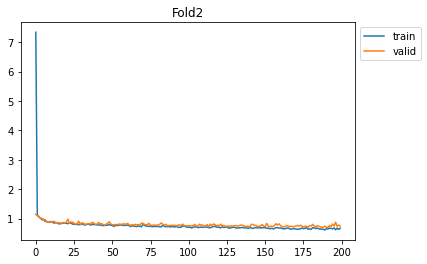

2021-07-21 06:09:02,539 - __main__ - DEBUG - Complete prediction for train fold (5199.316 seconds passed)
2021-07-21 06:09:04,762 - __main__ - DEBUG - Complete prediction for val fold (5201.539 seconds passed)
2021-07-21 06:09:17,724 - __main__ - DEBUG - Complete prediction for test fold (5214.501 seconds passed)
2021-07-21 06:09:17,750 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp022/cv_fold2_training.csv (5214.527 seconds passed)
2021-07-21 06:09:17,763 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp022/cv_fold2_validation.csv (5214.540 seconds passed)
2021-07-21 06:09:17,786 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp022/cv_fold2_test.csv (5214.564 seconds passed)
2021-07-21 06:09:17,814 - __main__ - DEBUG - Save model ../scripts/../experiments/exp022/cv_fold2_model.torch (5214.591 seconds passed)
2021-07-21 06:09:17,944 - __main__ - DEBUG - Complete fold 2 (5214.721 seconds passed)
2021-07-21 06:09:17,947

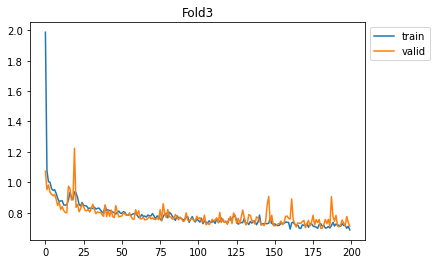

2021-07-21 06:43:22,459 - __main__ - DEBUG - Complete prediction for train fold (7259.236 seconds passed)
2021-07-21 06:43:24,651 - __main__ - DEBUG - Complete prediction for val fold (7261.428 seconds passed)
2021-07-21 06:43:37,343 - __main__ - DEBUG - Complete prediction for test fold (7274.120 seconds passed)
2021-07-21 06:43:37,364 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp022/cv_fold3_training.csv (7274.141 seconds passed)
2021-07-21 06:43:37,376 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp022/cv_fold3_validation.csv (7274.154 seconds passed)
2021-07-21 06:43:37,400 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp022/cv_fold3_test.csv (7274.178 seconds passed)
2021-07-21 06:43:37,429 - __main__ - DEBUG - Save model ../scripts/../experiments/exp022/cv_fold3_model.torch (7274.206 seconds passed)
2021-07-21 06:43:37,570 - __main__ - DEBUG - Complete fold 3 (7274.347 seconds passed)
2021-07-21 06:43:37,574

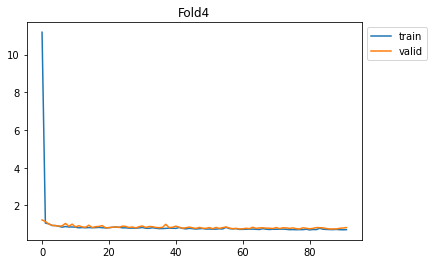

2021-07-21 06:59:27,021 - __main__ - DEBUG - Complete prediction for train fold (8223.798 seconds passed)
2021-07-21 06:59:29,259 - __main__ - DEBUG - Complete prediction for val fold (8226.036 seconds passed)
2021-07-21 06:59:41,930 - __main__ - DEBUG - Complete prediction for test fold (8238.707 seconds passed)
2021-07-21 06:59:41,951 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp022/cv_fold4_training.csv (8238.728 seconds passed)
2021-07-21 06:59:41,962 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp022/cv_fold4_validation.csv (8238.739 seconds passed)
2021-07-21 06:59:41,987 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp022/cv_fold4_test.csv (8238.764 seconds passed)
2021-07-21 06:59:42,034 - __main__ - DEBUG - Save model ../scripts/../experiments/exp022/cv_fold4_model.torch (8238.811 seconds passed)
2021-07-21 06:59:42,183 - __main__ - DEBUG - Complete fold 4 (8238.961 seconds passed)
2021-07-21 06:59:42,187

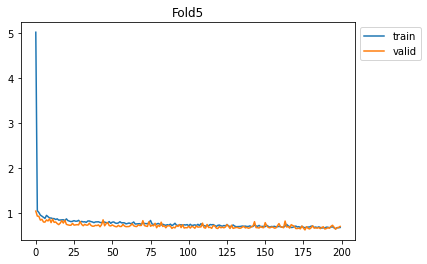

2021-07-21 07:34:04,531 - __main__ - DEBUG - Complete prediction for train fold (10301.308 seconds passed)
2021-07-21 07:34:06,723 - __main__ - DEBUG - Complete prediction for val fold (10303.500 seconds passed)
2021-07-21 07:34:19,332 - __main__ - DEBUG - Complete prediction for test fold (10316.109 seconds passed)
2021-07-21 07:34:19,355 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp022/cv_fold5_training.csv (10316.132 seconds passed)
2021-07-21 07:34:19,367 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp022/cv_fold5_validation.csv (10316.144 seconds passed)
2021-07-21 07:34:19,395 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp022/cv_fold5_test.csv (10316.172 seconds passed)
2021-07-21 07:34:19,422 - __main__ - DEBUG - Save model ../scripts/../experiments/exp022/cv_fold5_model.torch (10316.199 seconds passed)
2021-07-21 07:34:19,577 - __main__ - DEBUG - Complete fold 5 (10316.354 seconds passed)


In [21]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values

    torch.cuda.empty_cache()
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
            logger.debug('Complete prediction for {} fold ({:.3f} seconds passed)' \
                         .format(fold_, time.time() - SINCE))
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [22]:
rmse = partial(mean_squared_error, squared=False)

In [23]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [24]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [25]:
metrics = defaultdict(list)

## Training set

In [26]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-21 07:34:19,641 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-21 07:34:19,674 - __main__ - DEBUG - Loss: 0.7451675782988431
2021-07-21 07:34:19,675 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-21 07:34:19,687 - __main__ - DEBUG - Loss: 0.7547219872023893
2021-07-21 07:34:19,688 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-21 07:34:19,700 - __main__ - DEBUG - Loss: 0.8005575742404599
2021-07-21 07:34:19,701 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-21 07:34:19,713 - __main__ - DEBUG - Loss: 0.8157551943317054
2021-07-21 07:34:19,714 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-21 07:34:19,726 - __main__ - DEBUG - Loss: 0.7706769961211187


In [27]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.28037,1
00309fb1ef05416f9c1f,1.71321,3
003a1562e97f79ba96dc,1.93738,3
004890880e8e7431147b,0.88199,2
00718c32602425f504c1,1.79825,3
...,...,...
ffa3259fff8e6f3818a1,1.98574,3
ffd4d361756587883e48,1.03821,1
ffd794b7b311b7b7fd92,1.62179,2


In [28]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-21 07:34:19,783 - __main__ - INFO - Training loss: 0.8581572751054102


In [29]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-21 07:34:19,809 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp022/prediction_train.csv


## Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-21 07:34:19,839 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-21 07:34:19,850 - __main__ - DEBUG - Loss: 0.8290480472982745
2021-07-21 07:34:19,851 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-21 07:34:19,862 - __main__ - DEBUG - Loss: 0.8359439584336813
2021-07-21 07:34:19,863 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-21 07:34:19,874 - __main__ - DEBUG - Loss: 0.8339096715160893
2021-07-21 07:34:19,875 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-21 07:34:19,889 - __main__ - DEBUG - Loss: 0.8670571111000495
2021-07-21 07:34:19,890 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-21 07:34:19,904 - __main__ - DEBUG - Loss: 0.7932885113282975


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.30711,1
00309fb1ef05416f9c1f,0.46990,3
003a1562e97f79ba96dc,0.46808,3
004890880e8e7431147b,0.19789,2
00718c32602425f504c1,0.47290,3
...,...,...
ffa3259fff8e6f3818a1,0.43714,3
ffd4d361756587883e48,0.29266,1
ffd794b7b311b7b7fd92,0.36410,2


In [32]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-21 07:34:19,955 - __main__ - INFO - Validatino loss: 1.7099108930902038


In [33]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-21 07:34:19,984 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp022/prediction_valid.csv


In [34]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-21 07:34:20,002 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp022/metrics.json


# Prediction

In [35]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.31851
000bd5e82eb22f199f44,2.39019
0015f44de1854f617516,1.69354
00388a678879ba1efa27,1.95889
005e1e7c6496902d23f3,0.71394
...,...
ffbe65ad399b632dcbd0,2.22671
ffd7b2d646c0320c311a,1.27465
ffdb93ede17d4501e530,1.68600


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.31851
1,2.39019
2,1.69354
3,1.95889
4,0.71394
...,...
5914,2.22671
5915,1.27465
5916,1.68600
5917,1.84790


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-21 07:34:20,150 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp022/022_submission.csv


2021-07-21 07:34:20,319 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp022/prediction.png


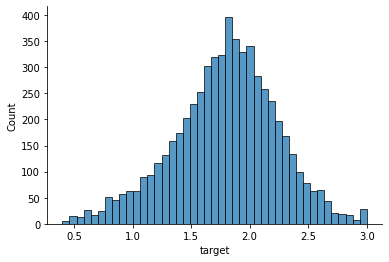

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 07:34:20,552 - __main__ - DEBUG - Complete (10317.329 seconds passed)
